# C1 - Content Based Image Retrieval
### Team 8 - Week 3

In [1]:
import re, os, glob, math, tqdm, pickle, itertools
import matplotlib.pyplot as plt

import numpy as np
import cv2

import pytesseract
from Levenshtein import distance as levenshtein_distance

import pywt
from skimage.feature import local_binary_pattern
from scipy.fftpack import dctn

# Path to the OCR executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\Luis\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

In [11]:
# This function extracts a specific text pattern from a file.
def get_text_bbdd(path):

    with open(path, 'r') as f:
        line = f.readlines()
        
    # Loop through each line in the file.
    for l in line:
        # Check if the line contains a pattern that starts with "(' and ends with ')".
        if re.search(r"\('([^']+)'", l.split(',')[0]):
            # If pattern is found, return the text inside the parentheses.
            return re.search(r"\('([^']+)'", l.split(',')[0]).group(1)
        else:
            # If pattern is not found, return 'Unknown'.
            return 'Unknown'

# Create a set to store unique names of authors.
name_bag = set()

for folder in ['BBDD', 'qsd1_w3', 'qsd2_w3']:
    # Loop through each .txt file inside the folder.
    for text_file in glob.glob(f'data/{folder}/*.txt'):
        # Extract the specific text pattern from the file and add it to the set.
        name_bag.add(get_text_bbdd(text_file))

In [3]:
class DataLoader():
    def __init__(self, folder_path):
        self.folder_path = folder_path

    # Obtain the painting image removing the background. 
    # It returns the mask where 1 means painting image and 0 background.
    def get_mask(self, img, threshold_area=71000):

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
     
        # Empty mask definition
        mask = np.zeros(gray.shape, dtype=np.uint8)

        # Applying gaussian blurring and define an intelligent gradient threshold depending on 13x13 boxes
        blur = cv2.GaussianBlur(gray, (13,13), 0)
        # Threshold based on local pixel neighborhood (11x11 block size)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

        # Two pass dilate with horizontal and vertical kernel
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
        dilate = cv2.dilate(thresh, horizontal_kernel, iterations=2)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
        dilate = cv2.dilate(dilate, vertical_kernel, iterations=2)

        # Find contours, filter using contour threshold area, and draw rectangle
        cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

        # Filtering the found contours by size
        counter = 0
        areas = []
        coordinates = []
        for c in cnts:
            # Shoelace formula for convex shapes
            area = cv2.contourArea(c) 
            if area > threshold_area:
                x,y,w,h = cv2.boundingRect(c) 
                areas.append((area, (x,y,w,h)))
                counter += 1

        # Sort areas and positions by area
        areas = sorted(areas, key=lambda x: x[0], reverse=True)

        # Draw bounding box on mask
        for i in range(min(len(areas), 2)):
            x,y,w,h = areas[i][1]
            coordinates.append((x,y,w,h))
            mask[y:y+h, x:x+w] = 255
        
        # Catching the 0 contours error
        if counter == 0:
            print('Error! No paintings in this image!')
            plt.imshow(img)
            plt.show()
            plt.imshow(mask, cmap='gray')
            plt.show()

        return mask, coordinates
    
    # Obtain the painting image removing the text. 
    # It returns the mask where 1 means painting image and 0 text.
    def get_mask_text(self, img):
        
        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply morphological opening and closing to enhance text-like features using a 9x9 kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
        opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
        
        #thresholding the difference to get (hopefully) only the text
        x = closing-opening
        x = (x>125).astype(np.uint8) 

        # Dilation to further enhance the text features using a 13x13 kernel
        kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (13,13))
        dilated = cv2.dilate(x, kernel2, iterations=2)

        # Find contours 
        ctns = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Loop through the contours and find rectangular bounding boxes that likely represent text areas
        areas = []
        for c in ctns[0]:
            x,y,w,h = cv2.boundingRect(c)
            # Filter out rectangles based on certain geometric criteria
            if w > h and w/h < 12 and (w*h)/(img.shape[0]*img.shape[1]) < 0.35:
                # Shoelace formula for convex shapes
                areas.append((cv2.contourArea(c), (x,y,w,h)))
        areas = sorted(areas, key=lambda x: x[0], reverse=True)
        x, y, w, h = areas[0][1]


        # Merge shapes close to the main detected text region (e.g., text broken into separate regions)
        for _, shape in areas:
            if y > shape[1]-10 and y < shape[1]+10:
                if shape[0] < x:
                    w = (x+w) - shape[0]
                    x = shape[0]
                else:
                    w = (shape[0]+shape[2]) - x

        # Extract the detected text region and apply OCR using Tesseract
        binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        text = pytesseract.image_to_string(binary[y:y+h, x:x+w])
        # Clean up the extracted text
        text = re.sub(r'[0-9\n¥“«!|]', '', text)

        # Compare the extracted text to known names using the Levenshtein distance to find the closest match from the bag of names
        min_dist = 1000000
        for name in name_bag:
            dist = levenshtein_distance(text, name)
            if dist < min_dist:
                min_dist = dist
                min_word = name
        
        # Return the bounding box of the detected text region and the closest matching name
        return [x, y, x+w, y+h, min_word]

    # Divide the image into blocks
    def create_blocks_array(self, image, blockNumber):
    
        # Set number of slices per axis
        axisSlice = int(math.sqrt(blockNumber))

        blocksArray = []
        # Split the image into vertical blocks
        split_h = np.array_split(image, axisSlice, axis = 0)
        
        for i in range(axisSlice):
            for j in range(axisSlice):
                # Split vertical blocks into square blocks
                split_hv = np.array_split(split_h[i], axisSlice, axis = 1)
                blocksArray.append(split_hv[j])
        return blocksArray

    # Compute the histogram of the image
    def create_histogram(self, block, mask, d_hist, mode, bins):
        channels = cv2.split(block)

        if mode == 'lab' and d_hist < 3: channels = channels[1:]
        
        range_a, range_b = 256, 256
        if mode == 'hsv': range_a = 180

        if d_hist == 1:
            if mask is None:
                # Compute 1D histograms for each channel separately
                hist = [cv2.calcHist([chan], [0], None, [bins], [0, range_a if i == 0 else range_b]) for i,chan in enumerate(channels)]
            else:
                # Compute 1D histograms for each channel separately
                hist = [cv2.calcHist([chan[mask!=0]], [0], None, [bins], [0, range_a if i == 0 else range_b]) for i,chan in enumerate(channels)]

        elif d_hist == 2:
            if mask is None:
                # Compute 2D joint histograms for each pair of channels
                hist = [cv2.calcHist([channels[i], channels[j]], [0, 1], None, [bins, bins], [0, range_a if i == 0 else range_b, 0, range_b])
                            for i in range(len(channels)) for j in range(i+1, len(channels))]
            else:
                # Compute 2D joint histograms for each pair of channels
                hist = [cv2.calcHist([channels[i][mask!=0], channels[j][mask!=0]], [0, 1], None, [bins, bins], [0, range_a if i == 0 else range_b, 0, range_b])
                            for i in range(len(channels)) for j in range(i+1, len(channels))]

        else:
            if mask is None:
                # Compute 3D joint histogram for all three channels
                hist, _ = np.histogramdd([c.flatten() for c in channels], bins=(bins, bins, bins), range=[(0, range_a), (0, range_b), (0, range_b)])
            else:
                # Compute 3D joint histogram for all three channels
                hist, _ = np.histogramdd([c[mask != 0] for c in channels], bins=(bins, bins, bins), range=[(0, range_a), (0, range_b), (0, range_b)])

        return hist
    
    # Compute the color histogram of the image by blocks
    def get_color_features_by_blocks(self, image, level, mode, d_hist, bins, mask_text):

        # Get blocks using multi-level resolution
        blocksArray = []
        for lvl in range(level+1):
            for b in self.create_blocks_array(image, (2**lvl)*(2**lvl)):
                blocksArray.append(b)

        if mask_text is not None:
            blocksMasks = []

            # We create a mask image blocking the bbox of the text
            # That image will be used to compute the histogram of the image without the text
            mask_text_image = np.ones(image.shape[:2], dtype=np.uint8)
            assert len(mask_text_image.shape) == 2, 'Mask must be a grayscale image'

            mask_text_image[mask_text[1]:mask_text[3], mask_text[0]:mask_text[2]] = 0

            # It is necessary to create the blocks of the mask image too
            for lvl in range(level+1):
                for b in self.create_blocks_array(mask_text_image, (2**lvl)*(2**lvl)):
                    blocksMasks.append(b)
        else:
            blocksMasks = [None]*len(blocksArray)

        histograms = []
        for block, mask_text_block in zip(blocksArray, blocksMasks):
            # Compute the histogram of the channel and append it to the list
            hist = self.create_histogram(block, mask_text_block, d_hist, mode, bins)
            if isinstance(hist, list):
                for h in hist:
                    histograms.append(h.flatten() / (block.shape[0]*block.shape[1]))
            else:
                histograms.append(hist.flatten()  / (block.shape[0]*block.shape[1]))
            
        # Concatenate all histograms into a single feature vector
        return np.concatenate(histograms)

    def zigzag_scan(self, image):
        rows, cols = image.shape
        solution = [[] for _ in range(rows + cols - 1)]
        
        for i in range(rows):
            for j in range(cols):
                sum_idx = i + j
                if (sum_idx % 2 == 0):
                    # add at beginning if even index
                    solution[sum_idx].insert(0, image[i,j])
                else:
                    # add at the end if odd index
                    solution[sum_idx].append(image[i,j])

        # flatten the result
        result = np.array([num for sublist in solution for num in sublist])
        return result

    # Compute different texture features by blocks
    def get_texture_features_by_blocks(self, image, level, mode, bins, lbp_radius, dct_n_coeffs, mask_text):
        
        # Get blocks using multi-level resolution
        blocksArray = []
        for lvl in range(level+1):
            for b in self.create_blocks_array(image, (2**lvl)*(2**lvl)):
                blocksArray.append(b)

        if mask_text is not None:
            blocksMasks = []

            # We create a mask image blocking the bbox of the text
            # That image will be used to compute the histogram of the image without the text
            mask_text_image = np.ones(image.shape[:2], dtype=np.uint8)

            # Assign zero to the region corresponding to the text
            mask_text_image[mask_text[1]:mask_text[3], mask_text[0]:mask_text[2]] = 0

            # It is necessary to create the blocks of the mask image too
            for lvl in range(level+1):
                for b in self.create_blocks_array(mask_text_image, (2**lvl)*(2**lvl)):
                    blocksMasks.append(b)
        else:
            blocksMasks = [None]*len(blocksArray)

        histograms = []
        # For each block and its corresponding text mask block, compute texture features
        for block, mask_text_block in zip(blocksArray, blocksMasks):
            
            # Use mask to remove text from block
            if mode == "dct":
                # Use mask to remove text from block
                if mask_text_block is not None:
                    block[mask_text_block==0] = 0
                dct2d_features = dctn(block, axes=(0, 1))

                # Get the top 'dct_n_coeffs' coefficients using zigzag scan
                zigzag = self.zigzag_scan(dct2d_features)
                histograms.append(zigzag[:dct_n_coeffs])

            # Compute LBP texture features
            elif mode == "lbp":
                n_points = 8 * lbp_radius
                lbp_features = local_binary_pattern(block, P=n_points, R=lbp_radius)

                # Compute histogram with or without mask
                hist = np.histogram(lbp_features if mask_text_block is None else lbp_features[mask_text_block!=0], bins=bins, range=(0, 256))[0]

                # Normalize histogram
                histograms.append(hist.flatten() / (lbp_features.shape[0]*lbp_features.shape[1]))
            
            # Compute Wavelet texture features
            elif mode == "wavelet":
                details = pywt.dwt2(block, 'bior1.3')
                approx, (h, v, d) = details # approx captures bigger details (more smooth than the original img), (h, v, d) capture de horizontal, vertical and diagonal "smaller" details
                
                if mask_text_block is not None:
                    # Resize the text mask to the size of the wavelet's resulting images
                    new_mask = cv2.resize(mask_text_block, approx.shape[::-1]).astype(bool) 

                # Create an histogram for each wavelet "image" and concatenate all of them
                final_hist = []
                for wt_img in [approx, h, v, d]:
                    hist = np.histogram(wt_img if mask_text_block is None else wt_img[new_mask != 0], bins=bins, range=(0, 256))[0]
                    final_hist.append(hist.flatten() / (wt_img.shape[0]*wt_img.shape[1]))
                histograms.append(np.concatenate(final_hist))
            
        # Concatenate all histograms into a single feature vector
        return np.concatenate(histograms)

    def clean_noise(self, image, k):
        return cv2.medianBlur(image, k)
    
    # Load data, calculate background and text masks (if necessary) and compute features
    def load_data(self, level = 3, d_hist = 1, bins = 8, remove_background=False, remove_text=False, lbp_radius=1, dct_n_coeffs=32, features_mode='color_features'):
        # Get a list of all image file names in the folder
        image_files = sorted(glob.glob(self.folder_path+'/*.jpg'))

        # Initialize an empty list to store the processed images and masks
        processed_features_rgb = dict()
        processed_features_hsv = dict()
        processed_features_lab = dict()
        processed_features_text = dict()
        processed_features_dct = dict()
        processed_features_lbp = dict()
        processed_features_wavelet = dict()
        processed_features_combined = dict()
        masks, masks_text = [], []

        # Iterate over each image file
        for f in tqdm.tqdm(image_files):
            
            # Get the image id from the file name. Depending on the OS, the path separator is different
            try:
                img_id = int(f.split('\\')[-1].split('.')[0].split('_')[-1])
            except:
                img_id = int(f.split('/')[-1].split('.')[0].split('_')[-1])

            # Load the image
            image = cv2.imread(f)
            # Convert the image from BGR to lab color space
            image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
            # Convert the image from BGR to HSV color space
            image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            # Clean noise of the image using median filter
            image, image_lab, image_hsv = self.clean_noise(image, k=3), self.clean_noise(image_lab, k=3), self.clean_noise(image_hsv, k=3)

            features_text = []
            features_rgb, features_hsv, features_lab = [], [], []
            features_dct, features_lbp, features_wavelet = [], [], []

            # Remove background (there can be 2 paintings in the same image)
            if remove_background:
                mask_image, coordinates = self.get_mask(image)
               
                # Remove the text from each image
                if remove_text:
                    coordinates = sorted(coordinates, key=lambda x: (x[0], x[1]))
                    masks_text_i = [[None]]*len(coordinates)

                    # coordinates contains the coordinates of the paintings mask in the image
                    # We iterate over each masked painting and get the text mask for each one
                    # We hace to recover the original coordinates for the text mask
                    for i, (x,y,w,h) in enumerate(coordinates):
                        x_text, y_text, w_text, h_text, text = self.get_mask_text(image[y:y+h, x:x+w])
                        features_text.append(text)
                        masks_text_i[i] = [x+x_text, y+y_text, x+x_text+w_text, y+y_text+h_text]
                    masks_text.append(masks_text_i)
                else:
                    for i in range(len(coordinates)):
                        masks_text.append([None])

            else:
                mask_image = None

                # if there is no background, the mask is the whole image
                coordinates = [[0,0,image.shape[1],image.shape[0]]] 
                if remove_text:
                    x_text, y_text, w_text, h_text, text = self.get_mask_text(image)
                    features_text.append(text)
                    masks_text.append([[x_text, y_text, w_text, h_text]])
                else:
                    masks_text.append([None])

            masks.append(mask_image)
        
            for i in range(len(coordinates)):
                x,y,w,h = coordinates[i]

                relative_mask_text = None
                if masks_text[-1][i] is not None:
                    relative_mask_text = [masks_text[-1][i][0]-x, masks_text[-1][i][1]-y, masks_text[-1][i][2]-x, masks_text[-1][i][3]-y]

                if features_mode == 'color_features' or features_mode == 'combined':    
                    # Get the features of every masked image
                    f = self.get_color_features_by_blocks(image[y:y+h, x:x+w], level-1, 'rgb', d_hist, bins, mask_text=relative_mask_text)
                    f_hsv = self.get_color_features_by_blocks(image_hsv[y:y+h, x:x+w], level, 'hsv', d_hist, bins, mask_text=relative_mask_text)
                    f_lab = self.get_color_features_by_blocks(image_lab[y:y+h, x:x+w], level, 'lab', d_hist, bins, mask_text=relative_mask_text)

                    features_rgb.append(f)
                    features_hsv.append(f_hsv)
                    features_lab.append(f_lab)

                if features_mode == 'texture_features' or features_mode == 'combined':
                    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    
                    f_dct = self.get_texture_features_by_blocks(image_gray[y:y+h, x:x+w], level, 'dct', bins, lbp_radius, dct_n_coeffs, mask_text=relative_mask_text)
                    f_lbp = self.get_texture_features_by_blocks(image_gray[y:y+h, x:x+w], level, 'lbp', bins, lbp_radius, dct_n_coeffs, mask_text=relative_mask_text)
                    f_wavelet = self.get_texture_features_by_blocks(image_gray[y:y+h, x:x+w], level, 'wavelet', bins, lbp_radius, dct_n_coeffs, mask_text=relative_mask_text)
                    
                    features_dct.append(f_dct)
                    features_lbp.append(f_lbp)
                    features_wavelet.append(f_wavelet)

            # Append the features to the dict
            if features_mode == 'texture_features':
                processed_features_dct[img_id] = features_dct
                processed_features_lbp[img_id] = features_lbp
                processed_features_wavelet[img_id] = features_wavelet
            
            elif features_mode == 'text_features':
                processed_features_text[img_id] = features_text

            elif features_mode == 'color_features':
                processed_features_rgb[img_id] = features_rgb
                processed_features_hsv[img_id] = features_hsv
                processed_features_lab[img_id] = features_lab
            
            elif features_mode == 'combined':
                if len(features_rgb) > 1:
                    assert len(features_rgb) == len(features_lbp) == len(features_text), 'The number of features must be the same for each mode!'
                    processed_features_combined[img_id] = [[features_rgb[0], features_wavelet[0], features_text[0]], [features_rgb[1], features_wavelet[1], features_text[1]]]
                else:
                    processed_features_combined[img_id] = [[features_rgb, features_wavelet, features_text]]
            
        # Change the return depending on the mode
        if features_mode == 'texture_features':
            return processed_features_dct, processed_features_lbp, processed_features_wavelet, masks, masks_text
        elif features_mode == 'text_features':
            return processed_features_text, masks, masks_text
        elif features_mode == 'color_features':
            return processed_features_rgb, processed_features_hsv, processed_features_lab, masks, masks_text
        elif features_mode == 'combined':
            return processed_features_combined, masks, masks_text
        

In [4]:
# Copied from https://github.com/benhamner/Metrics -> Metrics.Python.ml_metrics.average_precision.py
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

# Copied from https://github.com/benhamner/Metrics -> Metrics.Python.ml_metrics.average_precision.py
def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    result = []
    for a,p in zip(actual, predicted):
        for a_i, p_i in zip(a,p):
            result.append(apk([a_i],p_i,k))
    return np.mean(result)

# compute the histogram intersection between two feature vectors
def histogram_intersection(hist1, hist2, normalized=False):
    if normalized:
        return np.sum(np.minimum(hist1, hist2)) / np.sum(np.maximum(hist1, hist2))
    else:
        return np.sum(np.minimum(hist1, hist2))

# compute the euclidian distance between two feature vectors
def euclidian_distance(hist1, hist2):
    return np.sqrt(np.sum(np.square(hist1 - hist2)))

# compute the chi-squared distance between two feature vectors
def chi_squared_distance(hist1, hist2):
    return np.sum(np.square(hist1 - hist2) / (hist1 + hist2 + 1e-10))

# compute the bhattacharyya distance between two feature vectors
def bhattacharyya_distance(hist1, hist2):
    # Ensure that both histograms have the same shape
    assert hist1.shape == hist2.shape, "Histograms must have the same shape"
    # Calculate the Bhattacharyya coefficient
    bhattacharyya_coeff = np.sum(np.sqrt(hist1 * hist2))
    # Calculate the Bhattacharyya distance
    bhattacharyya_distance = -np.log(bhattacharyya_coeff)
    return bhattacharyya_distance

# compute the Helling distance (Hellinger kernel) between two feature vectors
def hellinger_kernel(hist1, hist2):
    return np.sum(np.sqrt(hist1*hist2))

def custom_leveshtein_distance(s1, s2, normalized=False):
    if normalized:
        return (max(len(s1), len(s2)) - levenshtein_distance(s1, s2)) / max(len(s1), len(s2))
    else:
        return levenshtein_distance(s1, s2)

# based on the solution in https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation by @Martin Thoma
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list ['x1', 'x2', 'y1', 'y2']
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : list ['x1', 'x2', 'y1', 'y2']
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

# Calculate Intersection over Union (IoU) for each query image and plot the results (if necessary).
def calculate_iou(gt_bboxes, pred_bboxes, do_plot=False):
    plot_rows, plot_cols = 4, 4

    # Plot config
    if do_plot:
        fig, ax = plt.subplots(nrows=plot_rows, ncols=plot_cols, figsize=(20, 20))

    # Get mean IoU score
    results = []
    for i, (q_gt, q_pred) in enumerate(zip(gt_bboxes, pred_bboxes)):
        for bbox_gt, bbox_pred in zip(q_gt, q_pred):
            bbox_gt_new = [bbox_gt[0][0], bbox_gt[0][1], bbox_gt[2][0], bbox_gt[2][1]]
            results.append(get_iou(bbox_pred, bbox_gt_new))

        if i < plot_rows*plot_cols and do_plot:
            im = cv2.imread(f"data/qsd1_w2/{str(i).zfill(5)}.jpg")
            plt_idx = np.unravel_index(i, (plot_rows, plot_cols))
            ax[plt_idx].imshow(im)
            ax[plt_idx].add_patch(plt.Rectangle(
                (bbox_gt_new[0], bbox_gt_new[1]), 
                bbox_gt_new[2]- bbox_gt_new[0],
                bbox_gt_new[3]- bbox_gt_new[1],
                edgecolor="green", facecolor="none", lw=2))
            ax[plt_idx].add_patch(plt.Rectangle(
                (bbox_pred[0], bbox_pred[1]), 
                bbox_pred[2]- bbox_pred[0],
                bbox_pred[3]- bbox_pred[1],
                edgecolor="red", facecolor="none", lw=2))
    if do_plot: plt.show()

    return np.mean(results)

In [5]:
# Obtain the closest k DDBB image for query images determined by the similarity function. 
# The features have been previously calculated from the developed method.
# It returns a list of lists with the k closest images for each query image. 
def compare_images(query_features, bbdd_features, k, sim_func, param=None, filter=False, combine=False):
    
    result = []
    for id1,f1 in query_features.items():
        result_i = []
        for f_i in f1:
            distances = []
            for id2,f2 in bbdd_features.items():
                text_bd = get_text_bbdd(f'data/BBDD/bbdd_{str(id2).zfill(5)}.txt')

                # Use the provided similarity function for comparing both paintings
                if not filter and not combine:
                    distances.append((id2, sim_func(f_i,f2)))
                    continue
                
                for f2_i in f2:
                    # First filter those paintings that have the same author. Then, compute similarity/distance for retrieval
                    if filter and text_bd == f_i[-1][0]:
                       distances.append((id2, param*sim_func(f_i[0][0], f2_i[0][0], normalized=True) + (1-param)*sim_func(f_i[1][0], f2_i[1][0], normalized=True)))
                    
                    # Use weighted sum between the color, texture and text scores as the similarity score for the retrieval
                    elif combine:
                        # If the similarity function is a distance 
                        if sim_func in [euclidian_distance, chi_squared_distance, bhattacharyya_distance, levenshtein_distance]:
                            distances.append(
                                (id2, 
                                param[0]*sim_func(f_i[0][0], f2_i[0][0], normalized=True) + 
                                param[1]*sim_func(f_i[1][0], f2_i[1][0], normalized=True) +
                                param[2]*(1 - custom_leveshtein_distance(f_i[2][0], text_bd, normalized=True))
                                ))
                        else:
                            distances.append(
                                (id2, 
                                param[0]*sim_func(f_i[0][0], f2_i[0][0], normalized=True) + 
                                param[1]*sim_func(f_i[1][0], f2_i[1][0], normalized=True) +
                                param[2]*custom_leveshtein_distance(f_i[2][0], text_bd, normalized=True)
                                ))
                
            #get k smallest values from distances   
            if sim_func in [euclidian_distance, chi_squared_distance, bhattacharyya_distance, levenshtein_distance]:
                k_smallest = sorted(distances, reverse=False, key=lambda x: x[1])[:k]
            else:
                k_smallest = sorted(distances, reverse=True, key=lambda x: x[1])[:k]
            result_i.append((id1, k_smallest))
            
        result.append(result_i)
    
    # Transform the result into the required format
    result2 = []
    for x in result:
        result2_i = []
        for y in x:
            result2_i.append([z[0] for z in y[1]])
        result2.append(result2_i)
    
    return result2

In [6]:
# Create DataLoader objects for both the database and the queries
data_loader = DataLoader('data/BBDD')
data_loader_qsd1_w3 = DataLoader('data/qsd1_w3')
data_loader_qsd2_w3 = DataLoader('data/qsd2_w3')

# Load ground truth files for each query
with open('data/qsd1_w3/gt_corresps.pkl', 'rb') as f:
    gt_w3_1 = pickle.load(f)

with open('data/qsd2_w3/gt_corresps.pkl', 'rb') as f:
    gt_w3_2 = pickle.load(f)

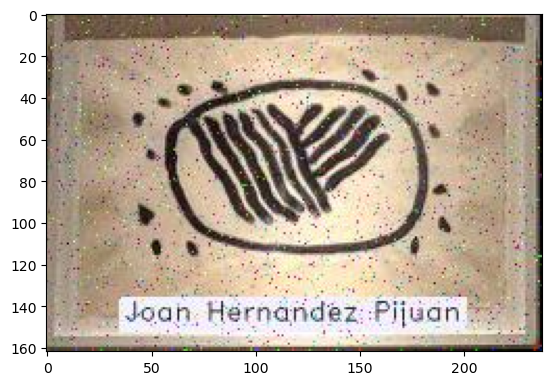

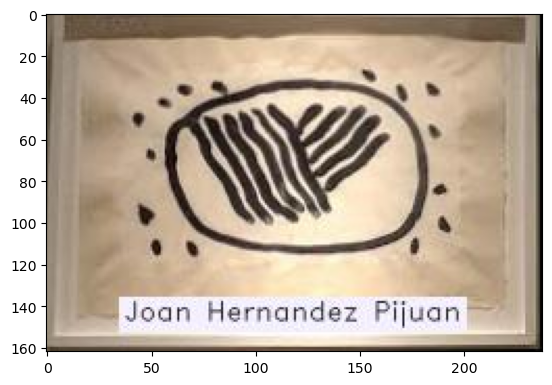

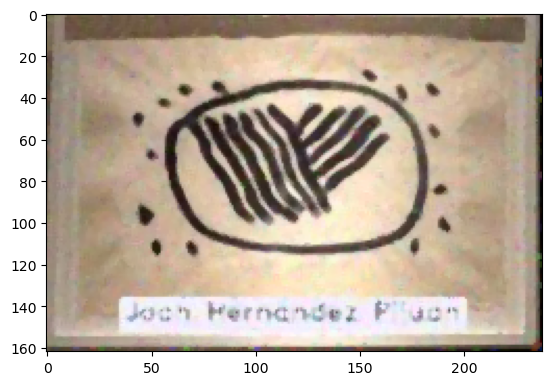

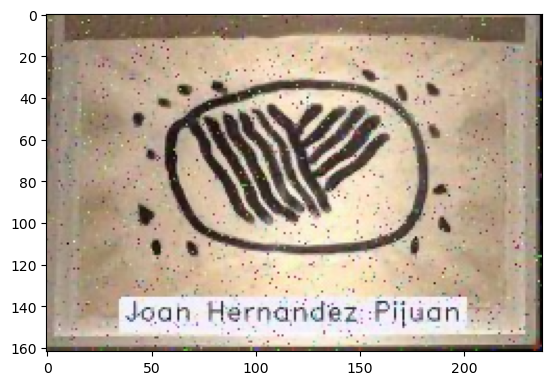

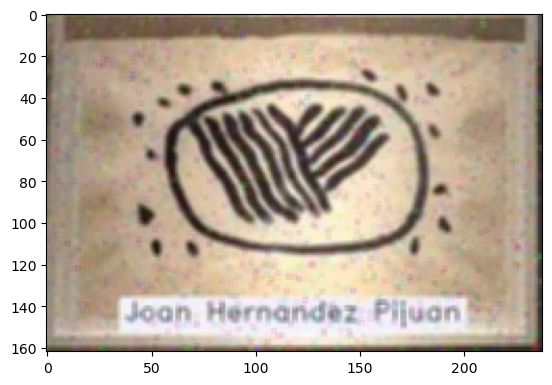

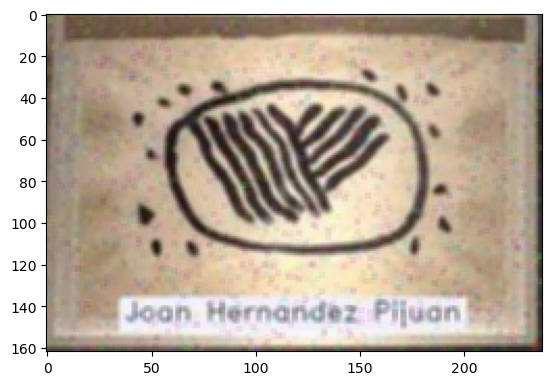

In [31]:
i = 8
img = cv2.imread(f'data/qsd1_w3/0000{i}.jpg', cv2.IMREAD_COLOR)[:, :, ::-1]
source_image =  cv2.imread(f'data/qsd1_w3/non_augmented/0000{i}.jpg', cv2.IMREAD_COLOR)[:, :, ::-1]
plt.imshow(img)
plt.show()
plt.imshow(source_image)
plt.show()

med = cv2.medianBlur(img, 3)
plt.imshow(med)
plt.show()

bilateral = cv2.bilateralFilter(img, 3, 75, 75)
plt.imshow(bilateral)
plt.show()

average = cv2.blur(img, (3,3))
plt.imshow(average)
plt.show()

gaussian = cv2.GaussianBlur(img, (3,3), 75)
plt.imshow(gaussian)
plt.show()

## Validation results

### Task 2: 

Evaluate query system using QSD1-W3 using only text and a similarity metric to compare text.

Compare with retrieval using only color descriptors.


In [ ]:
# Define best hyperparameters configuration
features_mode = 'text_features'
k = 5

# Calculate and store the bbdd text features
bbdd_text = dict()
for i, text_file in enumerate(glob.glob(f'data/BBDD/*.txt')):
    # read text file
    with open(text_file, 'r') as f:
        line = f.readlines()
    
    for l in line:
        if re.search(r"\('([^']+)'", l.split(',')[0]):
            author = re.search(r"\('([^']+)'", l.split(',')[0]).group(1)
            bbdd_text[i] = author

query_text, _, _ = data_loader_qsd1_w3.load_data(remove_text=True, features_mode=features_mode)

results = compare_images(query_text, bbdd_text, k, levenshtein_distance)
mapk_1 = mapk(gt_w3_1, results, k)
print(f'MAP@{k} for qsd1_w3: {mapk_1}')    
        

In [ ]:
k = 5
features_mode = 'color_features'
# Compute features for the database and the query images
features_rgb, features_hsv, features_lab, _, _ = data_loader.load_data(features_mode=features_mode, remove_background=False, level=2, d_hist=2, bins=8)
features_rgb_q1_w2, features_hsv_q1_w2, features_lab_q1_w2, _, _ = data_loader_qsd1_w3.load_data(features_mode=features_mode, remove_background=False, remove_text=True, level=2, d_hist=2, bins=8)

# Query 1: Results and mAP@k
for sim_func in [chi_squared_distance, histogram_intersection]:

    results_rgb_q1_w3 = compare_images(features_rgb_q1_w2, features_rgb, k, sim_func)
    results_hsv_q1_w3 = compare_images(features_hsv_q1_w2, features_hsv, k, sim_func)
    results_lab_q1_w3 = compare_images(features_lab_q1_w2, features_lab, k, sim_func)

    mapk_rgb_1 = mapk(gt_w3_1, results_rgb_q1_w3, k)
    mapk_hsv_1 = mapk(gt_w3_1, results_hsv_q1_w3, k)
    mapk_lab_1 = mapk(gt_w3_1, results_lab_q1_w3, k)

    print(f'RGB, {sim_func.__name__} = \tmAP@1: {mapk_rgb_1}')
    print(f'HSV, {sim_func.__name__} = \tmAP@1: {mapk_hsv_1}')
    print(f'LAB, {sim_func.__name__} = \tmAP@1: {mapk_lab_1}')

### Task 3:

Implement texture descriptors (LBP, DCT, wavelet-based, etc.)

Evaluate query system using QSD1-W3 using only texture descriptors.

In [ ]:
# Define grid search for hyperparameters configuration
k = [1,5]
bins = 8
dct_n_coeffs = [64,128,512]
features_mode = "texture_features"
level = [1,2,3]
lbp_radius = [1,2,3]

# Compute features for the database and the query images
for dct_n_coeff, lbp_r in zip(dct_n_coeffs, lbp_radius):
    for l in level:

        features_dct, features_lbp, features_wavelet, _, _ = data_loader.load_data(
            remove_background=False, remove_text=False, level=l, 
            bins=bins, dct_n_coeffs=dct_n_coeff, 
            features_mode=features_mode, lbp_radius=lbp_r)
        
        features_dct_q1_w3, features_lbp_q1_w3, features_wavelet_q1_w3, _, _ = data_loader_qsd1_w3.load_data(
            remove_background=False, remove_text=True, level=l, 
            bins=bins, dct_n_coeffs=dct_n_coeff, 
            features_mode=features_mode, lbp_radius=lbp_r)

        # Iterating through similarity functions and k values for mAP calculation
        for sim_func in [chi_squared_distance, histogram_intersection]:
            for ki in k:

                # Compare images to get similar results for different feature sets
                results_dct_q1_w3 = compare_images(features_dct_q1_w3, features_dct, ki, sim_func)
                results_lbp_q1_w3 = compare_images(features_lbp_q1_w3, features_lbp, ki, sim_func)
                results_wavelet_q1_w3 = compare_images(features_wavelet_q1_w3, features_wavelet, ki, sim_func)

                # Calculate mAP values for the retrieved results
                mapk_dct = mapk(gt_w3_1, results_dct_q1_w3, ki)
                mapk_lbp = mapk(gt_w3_1, results_lbp_q1_w3, ki)
                mapk_wavelet = mapk(gt_w3_1, results_wavelet_q1_w3, ki)

                # Print the mAP results
                print(f'DCT, {sim_func.__name__} = \tmAP@{ki}: {mapk_dct}')
                print(f'LBP, {sim_func.__name__} = \tmAP@{ki}: {mapk_lbp}')
                print(f'Wavelet, {sim_func.__name__} = \tmAP@{ki}: {mapk_wavelet}')

### Task 4:

Combine descriptors. Evaluate query system using QSD2-W3.


In [ ]:
k = [1,5]
features_mode = 'combined'
d_hist = 2
level = 3
bins = 8
# Compute features for the database and the query images
features, _, _ = data_loader.load_data(features_mode=features_mode, remove_background=False, level=level, d_hist=d_hist, bins=bins, lbp_radius=None)
features_q2_w3, _, _ = data_loader_qsd2_w3.load_data(features_mode=features_mode, remove_background=False, remove_text=True, level=level, d_hist=d_hist, bins=bins, lbp_radius=None)

### Filter by text

In [ ]:
# Grid search for lambda weight values
params = [0, 0.25, 0.5, 0.75, 1]

for p in params:
    for ki in k:
        results_q2_w3 = compare_images(features_q2_w3, features, ki, histogram_intersection, filter=True, param=p)
        mapk_1 = mapk(gt_w3_2, results_q2_w3, ki)
        print(f'Combined param {p}, histogram_intersection = \tmAP@{ki}: {mapk_1}')

In [ ]:
# Best result
results_q2_w3 = compare_images(features_q2_w3, features, 5, histogram_intersection, filter=True, param=0.5)
mapk_1 = mapk(gt_w3_2, results_q2_w3, 1)
mapk_5 = mapk(gt_w3_2, results_q2_w3, 5)
print(f'Combined param {0.5}, histogram_intersection = \tmAP@{1}: {mapk_1} mAP@{5}: {mapk_5}')

### Combine all three modalities (color, texture and text)

In [ ]:
# Grid search for lambda weight values
params_list = [
    [1, 1, 1], [1, 1, 0], [1, 0, 1], [1, 1, 0],
    [0.5, 0.25, 0.25], [0.25, 0.5, 0.25], [0.25, 0.25, 0.5],
    [0.5, 0.5, 0.25], [0.25, 0.5, 0.5], [0.5, 0.25, 0.5],
    [0.7, 0.15, 0.15], [0.15, 0.7, 0.15], [0.15, 0.15, 0.7],
]

results = []
params_list = list(itertools.product([0,1,2,4,6,10,15], repeat=3))
for params in tqdm.tqdm(params_list):
    # Compute features for the database and the query images
    results_q2_w3 = compare_images(features_q2_w3, features, 5, histogram_intersection, combine=True, param=params)
    mapk_1 = mapk(gt_w3_2, results_q2_w3, 1)
    mapk_5 = mapk(gt_w3_2, results_q2_w3, 5)
    results.append({"params": params, "map1": mapk_1, "map5": mapk_5})
    print(f'Combined param {params}, histogram_intersection = \tmAP@{1}: {mapk_1}, mAP@{5}: {mapk_5}')